In [1]:
import numpy as np
from astropy.io import fits
from loguru import logger
from pathlib import Path

from surfh.Models import instru

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy import ndimage

from sklearn.decomposition import NMF
from einops import rearrange
from surfh.Models import wavelength_mrs
from surfh.Simulation import simulation_data
from matplotlib.widgets import Slider


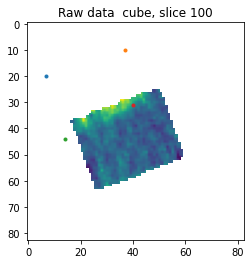

! (8687, 23, 30)
(0,)
(0,)


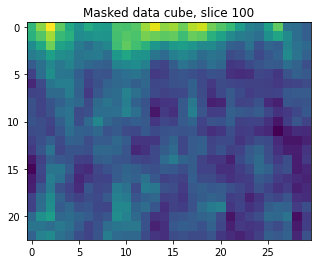

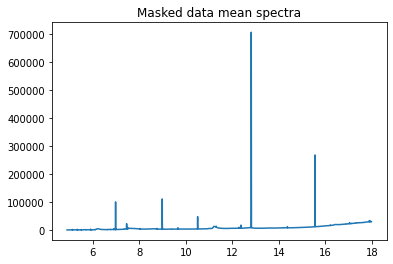

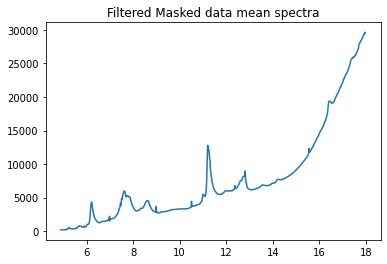

In [8]:
hdul = fits.open('/home/nmonnier/Data/JWST/Orion_bar/Fusion/ChannelCube_ch1-2-3-4-shortmediumlong_s3d.fits')
data_cube = hdul[1].data
raw_data_cube = hdul[1].data
hdr = hdul[1].header
wavel = np.array(hdul[5].data[0])[0,:,0]

wavel = wavel[:-10]
data_cube = data_cube[:-10,:,:]
raw_data_cube = raw_data_cube[:-10,:,:]

# Get wavel idx value to keep only 3 Channels
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

idx_chan3 = find_nearest(wavel, 17.98)
wavel = wavel[:idx_chan3]
data_cube = data_cube[:idx_chan3,:,:]
raw_data_cube = raw_data_cube[:idx_chan3,:,:]



plt.figure()
plt.title("Raw data  cube, slice 100")
plt.imshow(raw_data_cube[100])
plt.plot(7,20,'.')
plt.plot(37,10,'.')
plt.plot(14,44,'.')
plt.plot(40,31,'.')
plt.show()

coords = [(22,31), (22,54), (52,54), (52,31)]


from scipy.ndimage import rotate

angle = -20  # angle en degrés

# Créer un nouveau cube pour stocker les résultats
rotated_cube = np.empty_like(raw_data_cube)
raw_data_cube[np.isnan(raw_data_cube)] = 0
# Appliquer la rotation pour chaque tranche spectrale
for i in range(raw_data_cube.shape[0]):
    # Appliquer la rotation en 2D en gardant le centre de la tranche comme centre de rotation
    rotated_cube[i] = rotate(raw_data_cube[i], angle=angle, reshape=False, axes=(1, 0), order=3, mode='nearest')


masked_array = rotated_cube[:, coords[0][1]:coords[2][1], coords[0][0]:coords[3][0]]

print("!",masked_array.shape)
plt.figure()
plt.title("Masked data cube, slice 100")
plt.imshow(masked_array[100])


nan_idx = np.where(np.isnan(data_cube))
print(nan_idx[0].shape)
# replace Nan with 0
data_cube[np.isnan(data_cube)] = 0
fitlered_data_cube = ndimage.median_filter(data_cube.copy(), size=15, axes=[0])


nan_idx = np.where(np.isnan(masked_array))
print(nan_idx[0].shape)
# replace Nan with 0
masked_array[np.isnan(masked_array)] = 0
masked_array_fitlered_data_cube = ndimage.median_filter(masked_array.copy(), size=15, axes=[0])

data = rearrange(data_cube, 'L I J -> (I J) L') # from spectro data
masked_array_fitlered_data = rearrange(masked_array_fitlered_data_cube, 'L I J -> (I J) L') # from spectro data
plt.figure()
plt.title("Masked data mean spectra")
plt.plot(wavel, np.nanmean(masked_array, axis=(1,2)))
plt.figure()
plt.title("Filtered Masked data mean spectra")
plt.plot(wavel, np.nanmean(masked_array_fitlered_data_cube, axis=(1,2)))


/home/nmonnier/anaconda3/envs/surfh/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/nmonnier/anaconda3/envs/surfh/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/nmonnier/anaconda3/envs/surfh/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/nmonnier/anaconda3/envs/surfh/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/nmonnier/anaconda3/envs/surfh/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number 

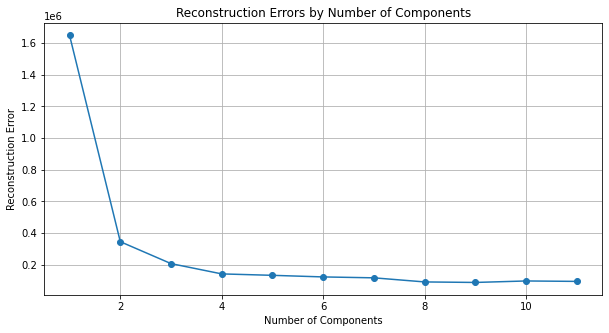

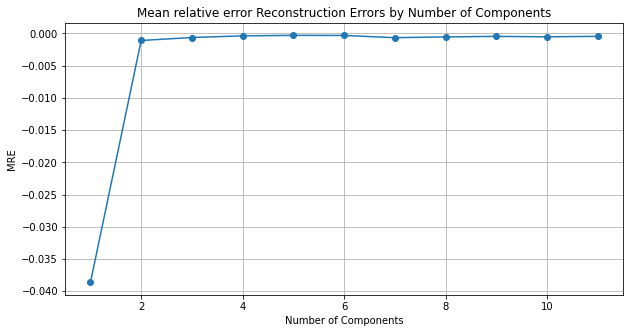

In [9]:
# Range of components to test
component_range = range(1, 12)  # Adjust based on how many tests you want to run

# List to store the reconstruction errors
reconstruction_errors = []
mre_reconstruction_errors = []

# Compute NMF for different numbers of components and calculate the reconstruction errors
for n_components in component_range:
    nmf = NMF(n_components=n_components, init='random', random_state=42)
    W = nmf.fit_transform(masked_array_fitlered_data)  # W is the weight matrix
    H = nmf.components_          # H is the feature matrix (components)
    reconstructed = W @ H        # Reconstruct the original matrix
    error = np.linalg.norm(masked_array_fitlered_data - reconstructed)  # Frobenius norm
    mre_error = np.mean(np.divide((masked_array_fitlered_data-reconstructed), masked_array_fitlered_data, out=np.zeros_like(masked_array_fitlered_data), where=masked_array_fitlered_data!=0))

    reconstruction_errors.append(error)
    mre_reconstruction_errors.append(mre_error)

# Plotting the reconstruction errors
plt.figure(figsize=(10, 5))
plt.plot(component_range, reconstruction_errors, marker='o')
plt.title('Reconstruction Errors by Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Reconstruction Error')
plt.grid(True)

# Plotting the reconstruction errors
plt.figure(figsize=(10, 5))
plt.plot(component_range, mre_reconstruction_errors, marker='o')
plt.title('Mean relative error Reconstruction Errors by Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('MRE')
plt.grid(True)

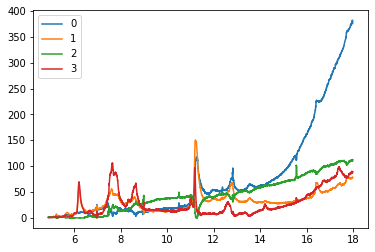

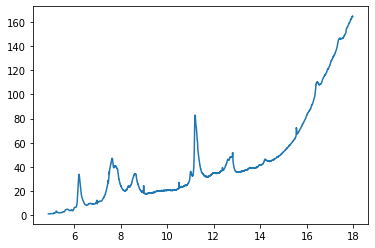

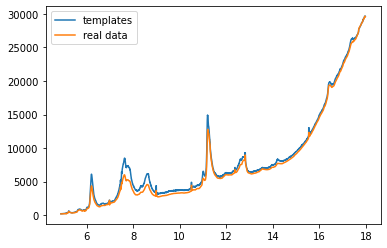

In [11]:
from sklearn.decomposition import NMF

# Initialize NMF with the desired number of components
nmf = NMF(n_components=4, init='random', random_state=0, max_iter=1000)

# Fit NMF model to your data
nmf.fit(masked_array_fitlered_data)

# Extract the components (eigenvectors)
components = nmf.components_

plt.figure()
for i in range(components.shape[0]):
    plt.plot(wavel, components[i], label=i)
plt.legend()
 
plt.figure()
plt.plot(wavel, np.mean(components, axis=0))

masked_array_fitlered_data_cube[masked_array_fitlered_data_cube==0] = np.nan
masked_array[masked_array==0] = np.nan

plt.figure()
scale_f = np.max(np.mean(masked_array_fitlered_data_cube, axis=(1,2)))/np.max(np.mean(components, axis=0))
#scale_f = np.mean(fitlered_data_cube, axis=(1,2))[-1]/np.mean(components, axis=0)[-1]

plt.plot(wavel, np.mean(components, axis=0)*scale_f, label='templates')
plt.plot(wavel, np.mean(masked_array_fitlered_data_cube, axis=(1,2)), label='real data')
plt.legend()


Shape wevel = (8687,), (2172,)


Text(0.5, 1.0, 'Mean compenents')

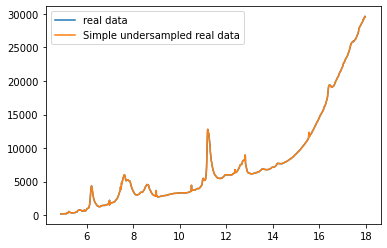

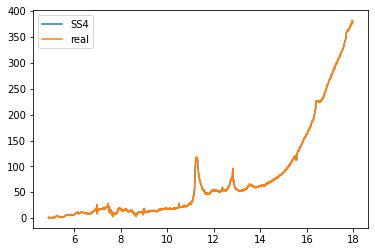

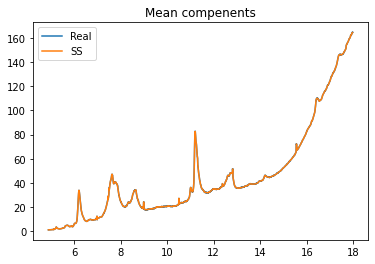

In [12]:
plt.plot(wavel, np.mean(masked_array_fitlered_data_cube, axis=(1,2)), label='real data')
plt.plot(wavel[::4], np.mean(masked_array_fitlered_data_cube[::4], axis=(1,2)), label='Simple undersampled real data')
plt.legend()
print(f"Shape wevel = {wavel.shape}, {wavel[::4].shape}")


SS_wavel = wavel[::4]
subsampled_interpn = np.zeros((components.shape[0], len(SS_wavel)))

for i in range(components.shape[0]):
    subsampled_interpn[i] = components[i,::4]

plt.figure()
plt.plot(SS_wavel, subsampled_interpn[0], label='SS4')
plt.plot(wavel, components[0], label='real')
plt.legend()


plt.figure()
plt.plot(wavel, np.mean(components, axis=0), label="Real")
plt.plot(SS_wavel, np.mean(subsampled_interpn, axis=0), label='SS')
plt.legend()
plt.title("Mean compenents")


In [13]:
np.save('/home/nmonnier/Data/JWST/Orion_bar/Fusion/Templates/nmf_orion_1ABC_2ABC_3ABC_4_templates_SS4.npy', subsampled_interpn)
np.save('/home/nmonnier/Data/JWST/Orion_bar/Fusion/Templates/wavel_axis_orion_1ABC_2ABC_3ABC_4_templates_SS4.npy', SS_wavel)
